In [1]:
# imports
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import math
from random import randrange
import pandas as pd
from datetime import datetime
import random
from main import predict
import networkx as nx
import matplotlib.pyplot as plt
from sentence_classifier import sc, dialogue_act_features

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/evam/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/evam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package nps_chat to /Users/evam/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!


In [2]:
# Load data
data = pd.read_csv('../Dataset/Ansar1.txt', sep='\t', lineterminator='\r')
data = data.sort_values('ThreadID')
# data.info

In [3]:
# Data preparation functions
def getUsers(posts): # posts is a dataframe
    return posts[['MemberID', 'MemberName']].drop_duplicates(subset='MemberID', keep="first").to_numpy()

def getUserIndex(userId):
#     userId = int(userId) if userId.isdigit() else -1
    index = np.where(allUsers == userId)[0][0]
    return index

def getThreads(posts): # posts is a dataframe
    posts = posts.to_numpy()
    threads = []
    threadId = -1
    for i in range(posts.shape[0]):
        if posts[i][1] == threadId:
            threads[len(threads) - 1].append(posts[i])
        else:
            threadId = posts[i][1]
            threads.append([posts[i]])
    threads = np.asarray([np.array(thread) for thread in threads]) # convert 3d matrix to numpy array
    return threads

def getDirectReceiver(text):
    directReceiverName = text.split(' ')[4]
    if np.where(allUsers == directReceiverName)[0].shape[0] != 0:
        directReceiverId = allUsers[np.where(allUsers == directReceiverName)[0][0]][0]
    else:
        directReceiverId = -1
    return [directReceiverId, directReceiverName]

def getMainText(fullText, directReceiver, possiblePosts):
    quotedText = ''
    for i in range(possiblePosts.shape[0]):
#         if possiblePosts[i][3] == directReceiver[0] and possiblePosts[i][5] in fullText:
        if type(possiblePosts[i][5]) == str and possiblePosts[i][5] in fullText:
            if(possiblePosts[i][5].startswith('Quote: Originally Posted by')):
                quotedText = getMainText(possiblePosts[i][5], getDirectReceiver(possiblePosts[i][5]), possiblePosts[:i])
            else:
                quotedText = possiblePosts[i][5]
            break
    mainText = fullText.replace('Quote: Originally Posted by ' + directReceiver[1] + ' ' + quotedText, '')
    return mainText
    

In [4]:
# Funtions used inside the algorithm
def getReplyInfo(post, thread): # returns [isDirect, directReceiverId, mainText]
    if type(post[5]) == str and post[5].startswith('Quote: Originally Posted by'):
        isDirect = True
        directReceiver = getDirectReceiver(post[5])
        mainText = getMainText(post[5], directReceiver, thread)
    else:
        isDirect = False
        directReceiver = [-1, '']
        mainText = post[5] if type(post[5]) == str else ''
    return [isDirect, directReceiver[0], mainText]

def checkIsQuestion(text):
    sentenceType = sc.classify(dialogue_act_features(text))
    return sentenceType == 'whQuestion' or sentenceType == 'ynQuestion'

def responseDelayInDays(messageDate, prevMessageDate):
    messageDate = datetime.strptime(messageDate, '%Y-%m-%d %H:%M:%S.%f')
    prevMessageDate = datetime.strptime(prevMessageDate, '%Y-%m-%d %H:%M:%S.%f')
    difference = messageDate - prevMessageDate
    return abs(difference.days)

def weight(days, isDirect, isQuestion):
    w = 1/(1 + days)
    if isQuestion:
        w = w+0.5 if isDirect==True else w
    else:
        w = w+1 if isDirect==True else w+0.5
    
    # divide weight by 2 to make sure it is always <=1
    return w


In [5]:
# Main Algorithm: generate SNWs
threads = getThreads(data)
allUsers = getUsers(data)
SNW = np.zeros((allUsers.shape[0], allUsers.shape[0]))

for thread in threads:
    for j in range(thread.shape[0]):
        authorId = thread[j][3]
        receiver = getReplyInfo(thread[j], thread)
        isQuestion = checkIsQuestion(receiver[2])
        for k in range(thread[:(j+1), :].shape[0]):
            days = responseDelayInDays(thread[j][9], thread[k][9])
            SNW[getUserIndex(authorId), getUserIndex(thread[k][3])] += weight(days, receiver[1], isQuestion)
            

/Library/Python/3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(-1.0742085481011137,
 1.0987718356238625,
 -1.0878173555373496,
 1.084989796519557)

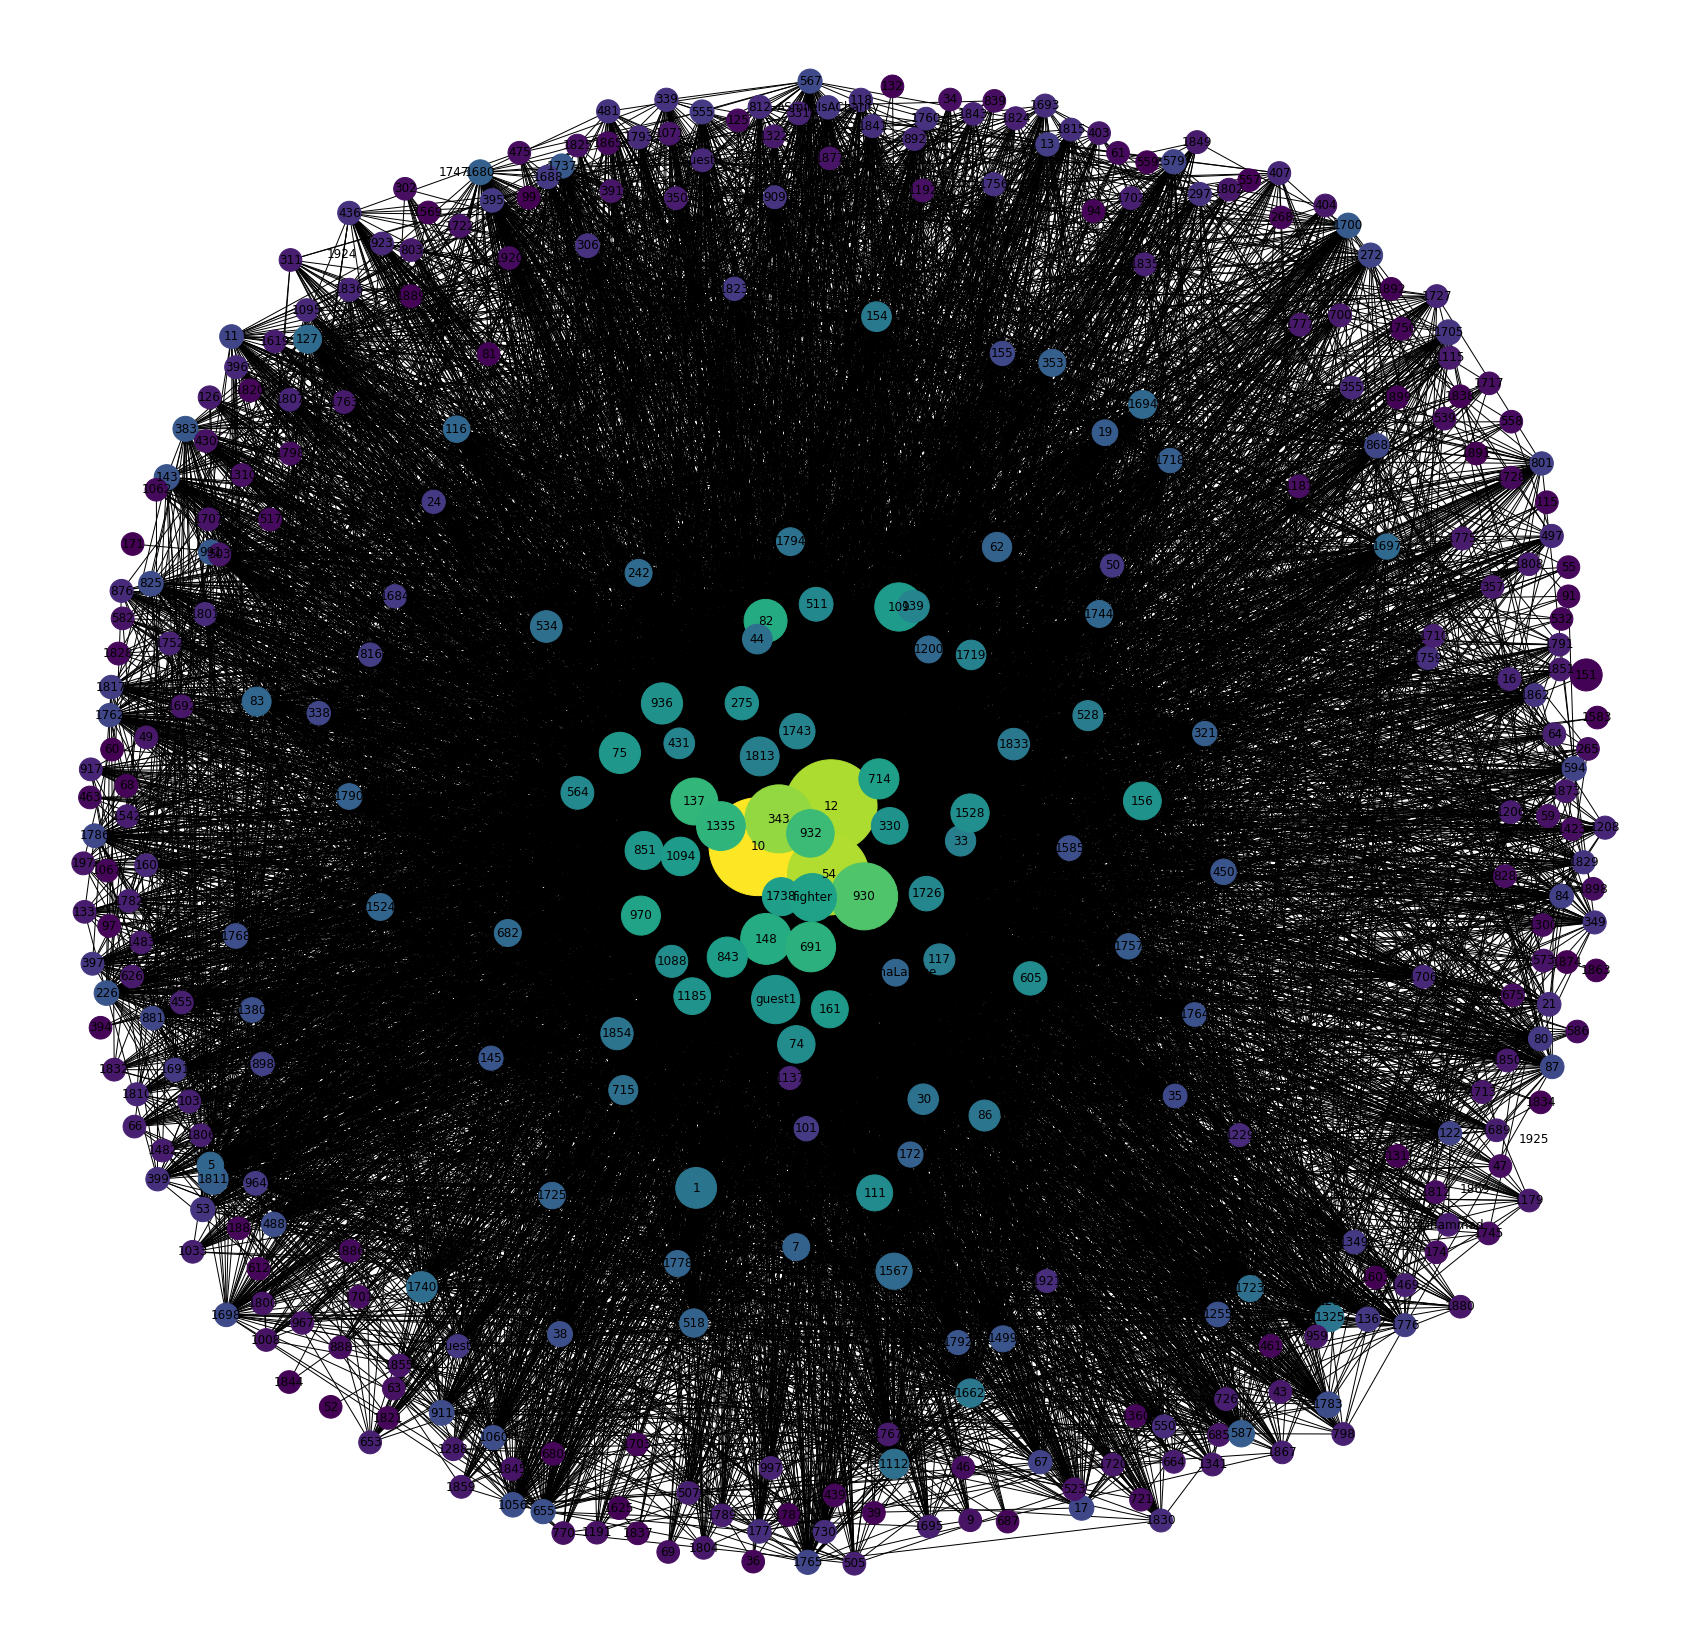

In [16]:
# generate graph
graph = nx.Graph()
for i in range(SNW.shape[0]):
    for j in range(SNW[i].shape[0]):
        if SNW[i][j] != 0:
            graph.add_edge(allUsers[i][0], allUsers[j][0], weight=SNW[i][j])
# sorted(betCent, key=betCent.get, reverse=True)[:10]

# plot graph
pos = nx.spring_layout(graph, 3)
betCent = nx.betweenness_centrality(graph, normalized=True, endpoints=True)
node_color = [20000.0 * graph.degree(v) for v in graph]
node_size =  [v * 100000 for v in betCent.values()]
plt.figure(figsize=(30,30))

nx.draw_networkx(graph, pos=pos, with_labels=True, node_color=node_color, node_size=node_size)
plt.axis('off')